In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
import plotly.express as px
from sklearn.metrics import silhouette_score, adjusted_rand_score, v_measure_score, homogeneity_score, completeness_score, adjusted_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import multivariate_normal
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from fcmeans import FCM

%matplotlib inline

# Подготовка к анализу

Получаем данные:

In [2]:
df = pd.read_csv('primary-tumor.csv')
df.head(5)

,class,age,sex,histologic-type,degree-of-diffe,bone,bone-marrow,lung,pleura,pertioneum,liver,brain,skin,neck,supraclavicular,axillar,mediastinum,adbdominal
0,1,1,1.0,NaN,3.0,2,2,1,2,2,2,2,2.0,2,2,2.0,2,2
1,1,1,1.0,NaN,3.0,2,2,2,2,2,1,2,2.0,2,1,2.0,1,2
2,1,1,2.0,2.0,3.0,1,2,2,2,2,2,2,2.0,2,2,2.0,1,2
3,1,1,2.0,NaN,3.0,1,2,1,1,2,2,2,2.0,2,2,2.0,1,2
4,1,1,2.0,NaN,3.0,1,2,1,1,2,2,2,2.0,2,2,2.0,1,2


Анализируем данные на пропуски и составляющие:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   class            339 non-null    int64  
 1   age              339 non-null    int64  
 2   sex              338 non-null    float64
 3   histologic-type  272 non-null    float64
 4   degree-of-diffe  184 non-null    float64
 5   bone             339 non-null    int64  
 6   bone-marrow      339 non-null    int64  
 7   lung             339 non-null    int64  
 8   pleura           339 non-null    int64  
 9   pertioneum       339 non-null    int64  
 10  liver            339 non-null    int64  
 11  brain            339 non-null    int64  
 12  skin             338 non-null    float64
 13  neck             339 non-null    int64  
 14  supraclavicular  339 non-null    int64  
 15  axillar          338 non-null    float64
 16  mediastinum      339 non-null    int64  
 17  adbdominal      

Информация о датасете:

1. class: lung, head & neck, esophasus, thyroid, stomach, duoden & sm.int, colon, rectum, anus, salivary glands, pancreas, gallblader, liver, kidney, bladder, testis, prostate, ovary, corpus uteri, cervix uteri, vagina, breast
2. age: <30, 30-59, >=60
3. sex: male, female
4. histologic-type: epidermoid, adeno, anaplastic
5. degree-of-diffe: well, fairly, poorly
6. bone: yes, no
7. bone-marrow: yes, no
8. lung: yes, no
9. pleura: yes, no
10. peritoneum: yes, no
11. liver: yes, no
12. brain: yes, no
13. skin: yes, no
14. neck: yes, no
15. supraclavicular: yes, no
16. axillar: yes, no
17. mediastinum: yes, no
18. abdominal: yes, no

Заполняем пропуски медианными значениями:

In [4]:
df.fillna(df.median(numeric_only=True).round(1), inplace=True)

In [5]:
df

,class,age,sex,histologic-type,degree-of-diffe,bone,bone-marrow,lung,pleura,pertioneum,liver,brain,skin,neck,supraclavicular,axillar,mediastinum,adbdominal
0,1,1,1.0,2.0,3.0,2,2,1,2,2,2,2,2.0,2,2,2.0,2,2
1,1,1,1.0,2.0,3.0,2,2,2,2,2,1,2,2.0,2,1,2.0,1,2
2,1,1,2.0,2.0,3.0,1,2,2,2,2,2,2,2.0,2,2,2.0,1,2
3,1,1,2.0,2.0,3.0,1,2,1,1,2,2,2,2.0,2,2,2.0,1,2
4,1,1,2.0,2.0,3.0,1,2,1,1,2,2,2,2.0,2,2,2.0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,22,2,2.0,2.0,3.0,2,2,2,2,2,2,2,2.0,2,2,1.0,2,2
335,22,2,2.0,2.0,3.0,2,2,2,2,2,2,2,2.0,2,2,1.0,2,2
336,22,2,2.0,2.0,3.0,1,2,2,2,2,2,2,2.0,2,1,1.0,2,2
337,22,3,2.0,2.0,2.0,2,2,2,2,2,2,2,2.0,1,1,1.0,2,2


Разделим переменные на целевую и предикторы:

In [6]:
target = df[df.columns[[0]]]
df = df.drop(df[df.columns[[0]]], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              339 non-null    int64  
 1   sex              339 non-null    float64
 2   histologic-type  339 non-null    float64
 3   degree-of-diffe  339 non-null    float64
 4   bone             339 non-null    int64  
 5   bone-marrow      339 non-null    int64  
 6   lung             339 non-null    int64  
 7   pleura           339 non-null    int64  
 8   pertioneum       339 non-null    int64  
 9   liver            339 non-null    int64  
 10  brain            339 non-null    int64  
 11  skin             339 non-null    float64
 12  neck             339 non-null    int64  
 13  supraclavicular  339 non-null    int64  
 14  axillar          339 non-null    float64
 15  mediastinum      339 non-null    int64  
 16  adbdominal       339 non-null    int64  
dtypes: float64(5), i

Изучим количество кластеров:

In [7]:
len(target.groupby('class').count())

21

Изучим нормальность и зависимость данных:

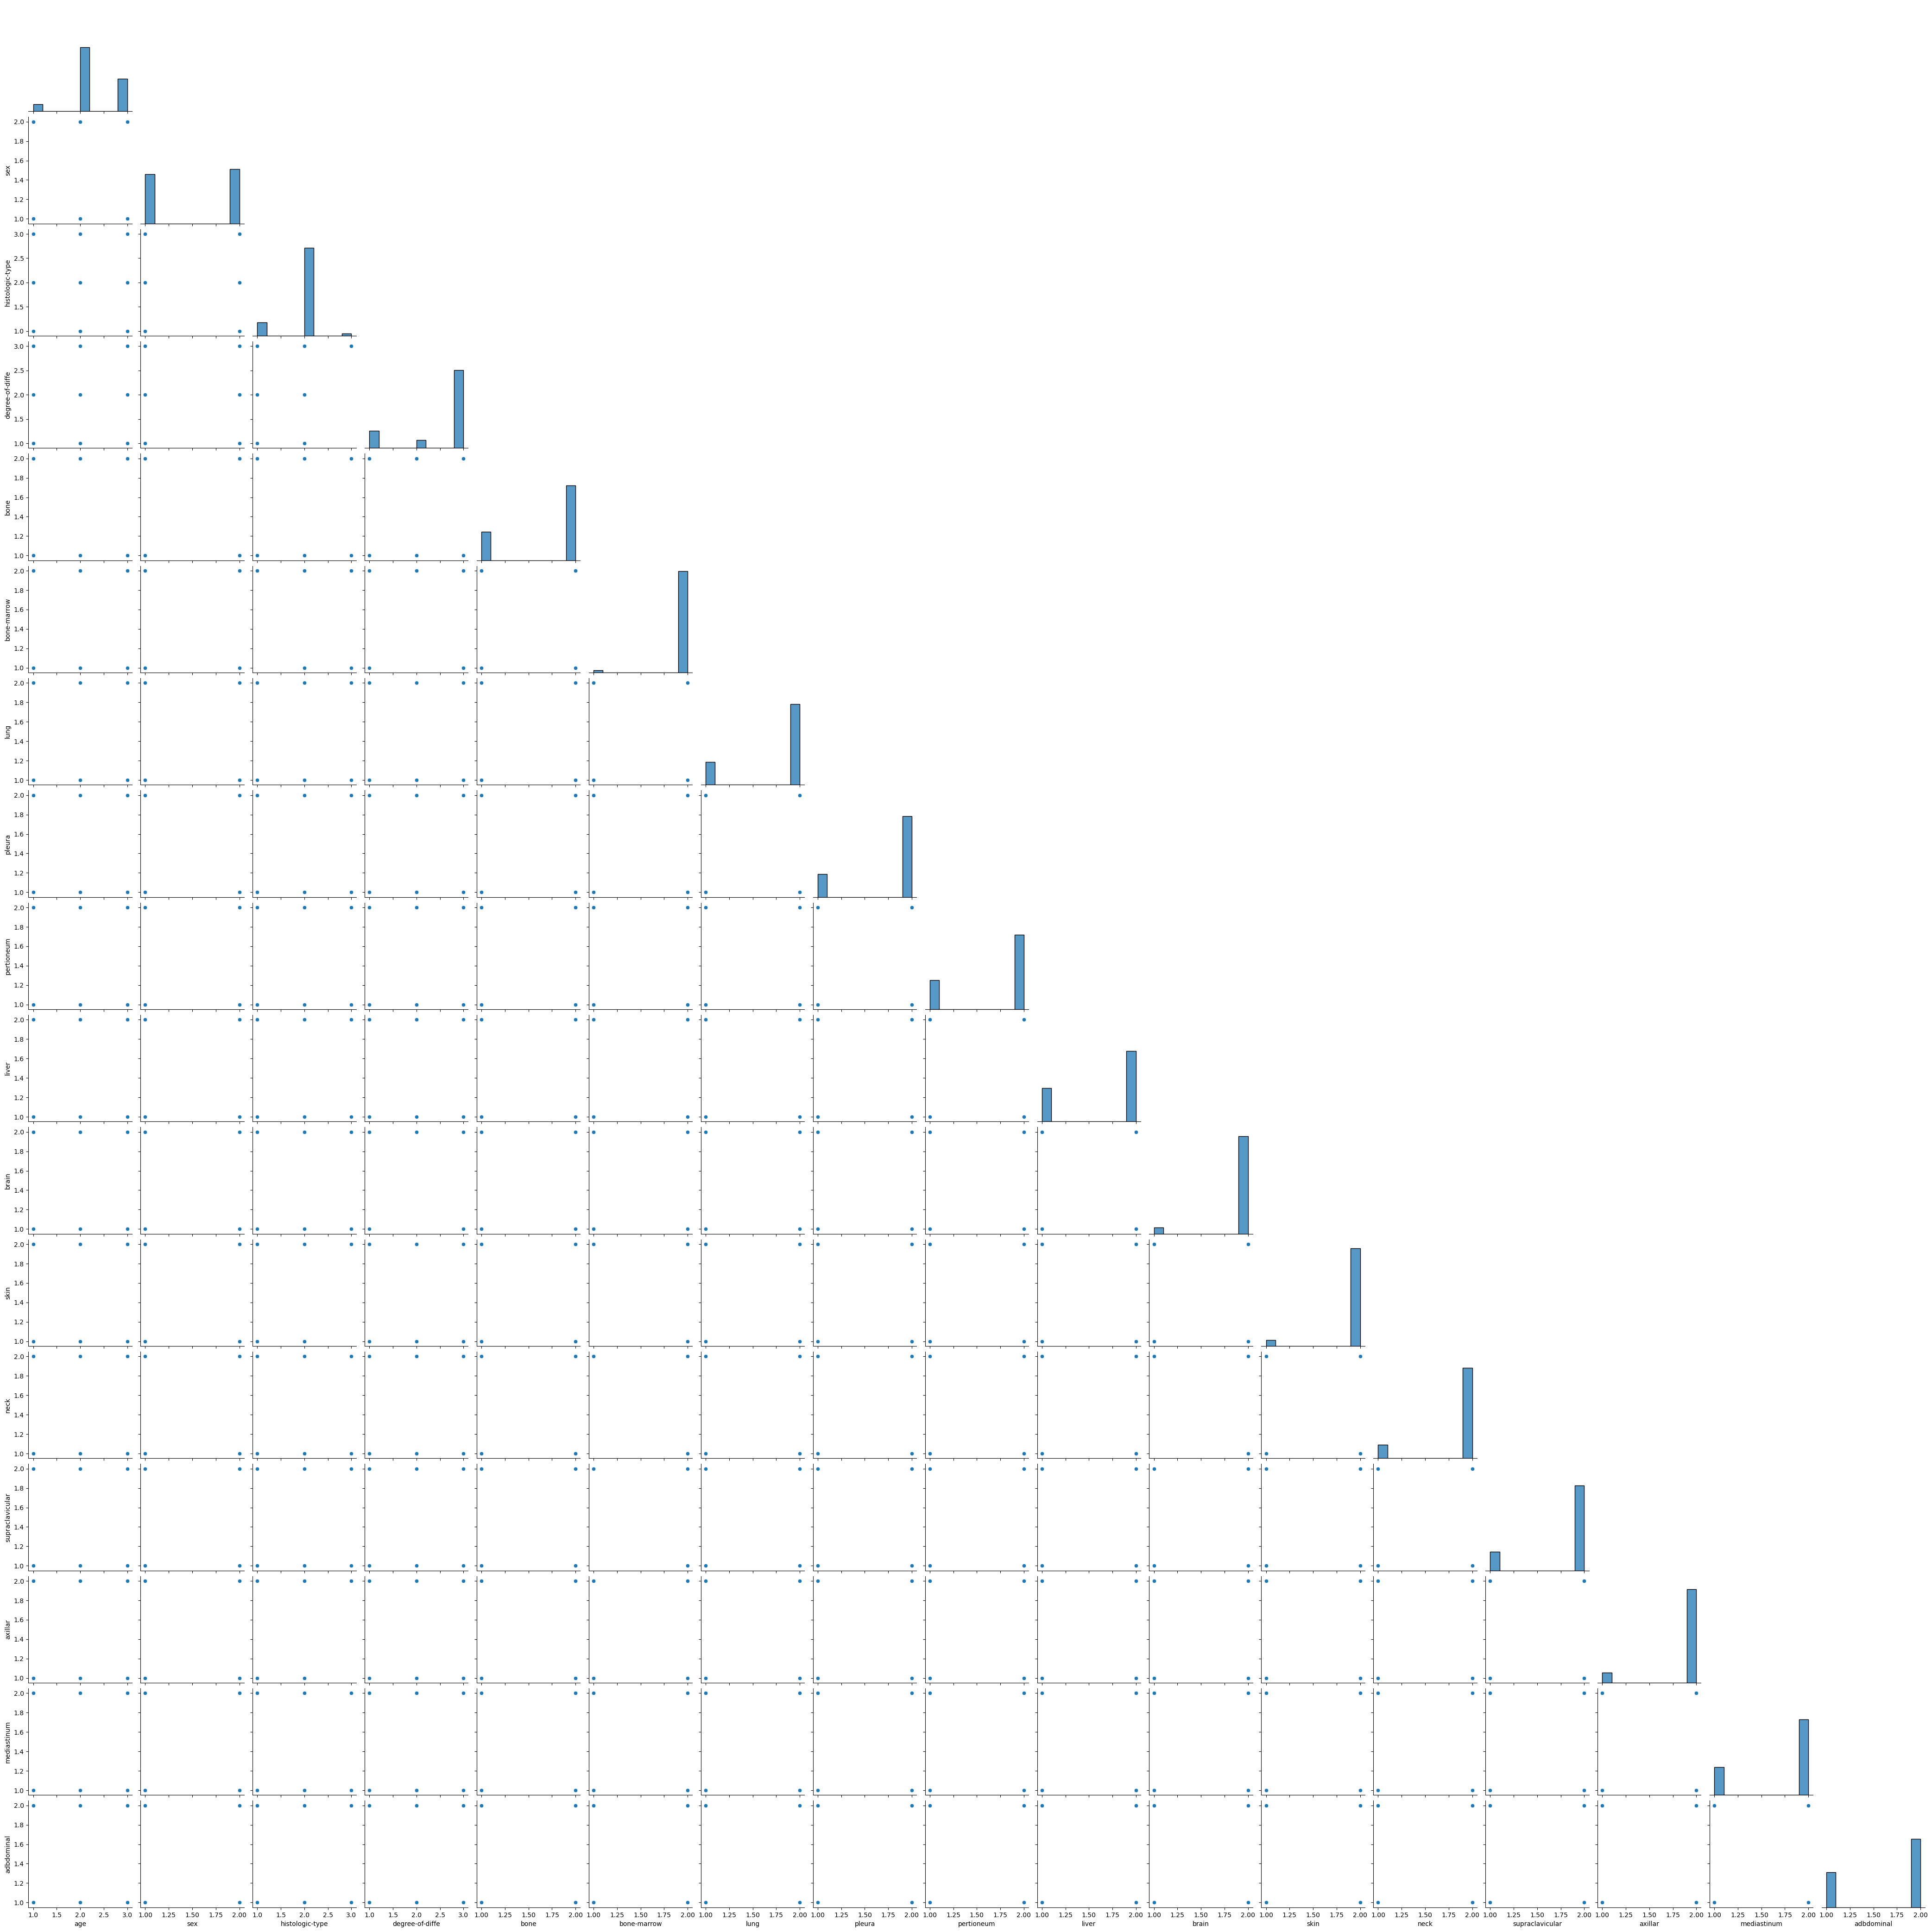

In [8]:
sns.pairplot(df, corner = True)

Большая часть данных распределена равномерно.

## Понижение размерности t-SNE

In [9]:
new_df = df.copy()
model = TSNE(perplexity=10, learning_rate=400, n_iter=5000)
transformed = model.fit_transform(new_df)

In [10]:
scaler = StandardScaler()
scaler.fit(transformed)
df = pd.DataFrame(scaler.transform(transformed), columns = ["Dimension_1", "Dimension_2"])

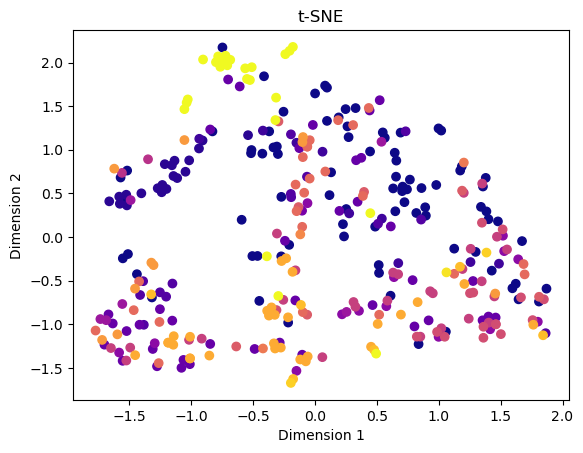

In [11]:
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c = target.values, cmap = plt.cm.plasma)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("t-SNE")
plt.show()

Методом t-SNE была понижена размерность с 17 до двух для дальнейшего анализа.

# Иерархические алгоритмы кластеризации данных

## Метод Варда

Построим дендрограмму c использованием метода Варда и Евклидового расстояния:

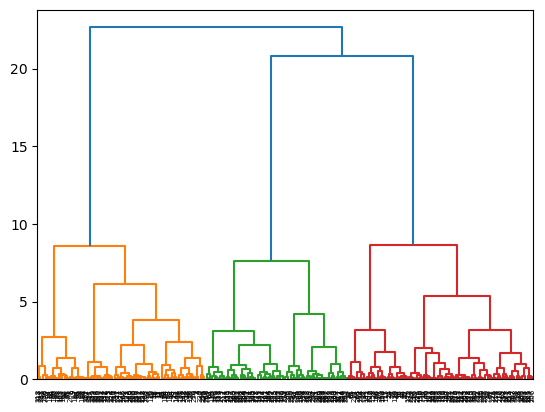

In [12]:
new_df = df.copy()
link = linkage(new_df, 'ward', 'euclidean')
dn = dendrogram(link)

Методом Варда было выделено 4 кластера:

In [13]:
result = pd.DataFrame(fcluster(link, 4, criterion='maxclust'), columns=['target'])

Text(0.5, 1.0, 'predicted cluster')

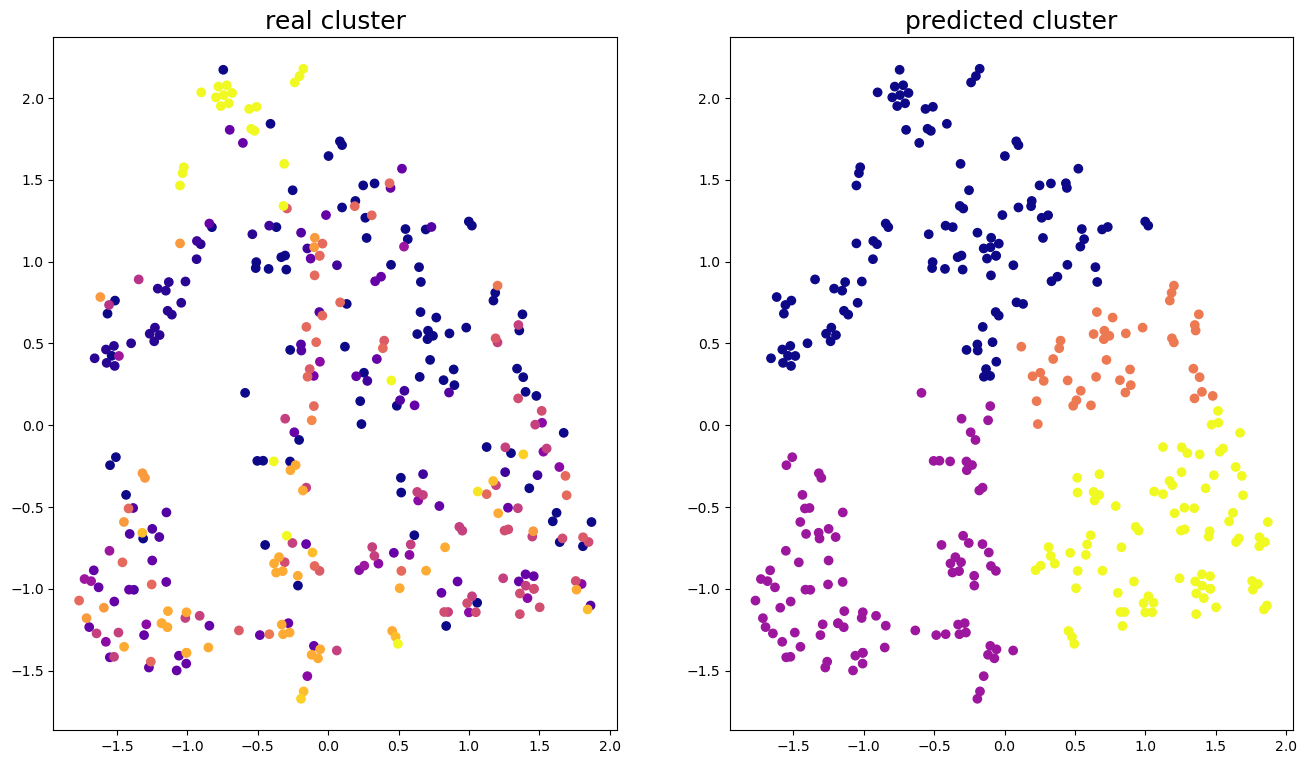

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16,9))
axes[0].scatter(new_df.iloc[:,0], new_df.iloc[:,1], c=target.values, cmap = plt.cm.plasma)
axes[0].set_title("real cluster", fontsize = 18)
axes[1].scatter(new_df.iloc[:,0], new_df.iloc[:,1], c=result.values, cmap = plt.cm.plasma)
axes[1].set_title("predicted cluster", fontsize = 18)

Оценим качество кластеризации:

In [15]:
print("Скорректированный индекс Рэнда: %0.3f" % adjusted_rand_score(target.values[:,0], result.values[:,0]))
print("Коэффициент изменения информации: %0.3f" % adjusted_mutual_info_score(target.values[:,0], result.values[:,0]))
print("Коэффициент качества кластеризации: %0.3f" % silhouette_score(new_df, result.values[:,0]))
print("Качество однородности: %0.3f" % homogeneity_score(target.values[:,0], result.values[:,0]))
print("Качество полноты: %0.3f" % completeness_score(target.values[:,0], result.values[:,0]))
print("Метрика V-Measure: %0.3f" % v_measure_score(target.values[:,0], result.values[:,0]))

Скорректированный индекс Рэнда: 0.072
Коэффициент изменения информации: 0.169
Коэффициент качества кластеризации: 0.384
Качество однородности: 0.160
Качество полноты: 0.304
Метрика V-Measure: 0.210


## Метод полной связи

Построим дендрограмму c использованием метода полной связи и Евклидового расстояния:

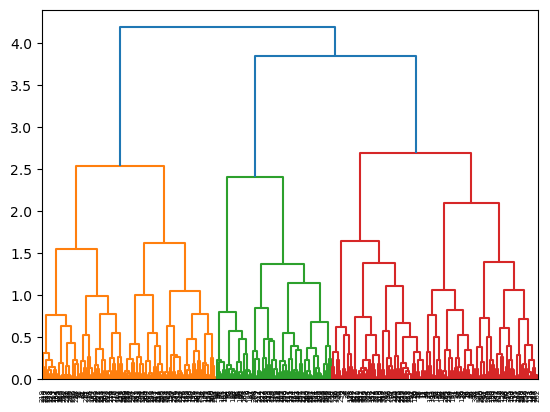

In [16]:
new_df = df.copy()
link = linkage(new_df, 'complete', 'euclidean')
dn = dendrogram(link)

Методом полной связи было выделено 4 кластера:

In [17]:
result = pd.DataFrame(fcluster(link, 4, criterion='maxclust'), columns=['target'])

Text(0.5, 1.0, 'predicted cluster')

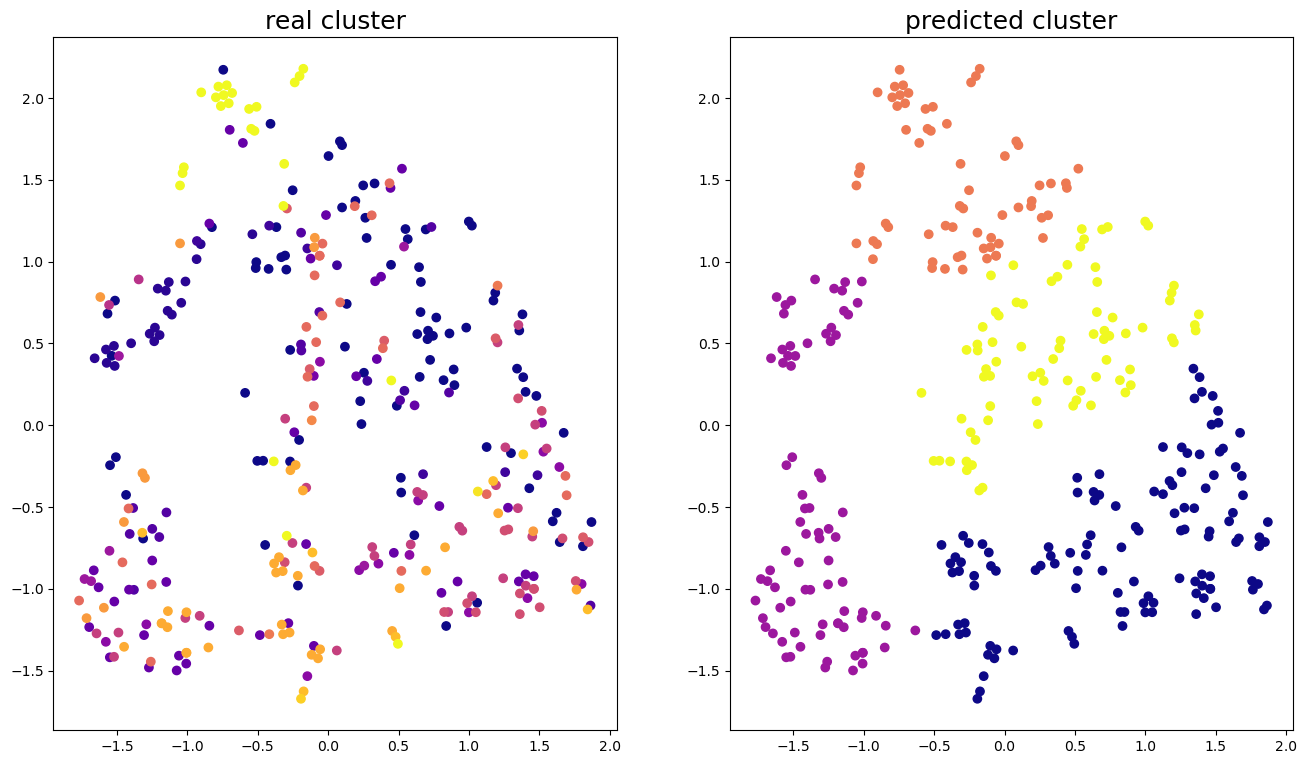

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16,9))
axes[0].scatter(new_df.iloc[:,0], new_df.iloc[:,1], c=target.values, cmap = plt.cm.plasma)
axes[0].set_title("real cluster", fontsize = 18)
axes[1].scatter(new_df.iloc[:,0], new_df.iloc[:,1], c=result.values, cmap = plt.cm.plasma)
axes[1].set_title("predicted cluster", fontsize = 18)

Оценим качество кластеризации:

In [19]:
print("Скорректированный индекс Рэнда: %0.3f" % adjusted_rand_score(target.values[:,0], result.values[:,0]))
print("Коэффициент изменения информации: %0.3f" % adjusted_mutual_info_score(target.values[:,0], result.values[:,0]))
print("Коэффициент качества кластеризации: %0.3f" % silhouette_score(new_df, result.values[:,0]))
print("Качество однородности: %0.3f" % homogeneity_score(target.values[:,0], result.values[:,0]))
print("Качество полноты: %0.3f" % completeness_score(target.values[:,0], result.values[:,0]))
print("Метрика V-Measure: %0.3f" % v_measure_score(target.values[:,0], result.values[:,0]))

Скорректированный индекс Рэнда: 0.072
Коэффициент изменения информации: 0.167
Коэффициент качества кластеризации: 0.369
Качество однородности: 0.160
Качество полноты: 0.297
Метрика V-Measure: 0.208


##  Метод средней связи

Построим дендрограмму c использованием с метода средней и Евклидового расстояния:

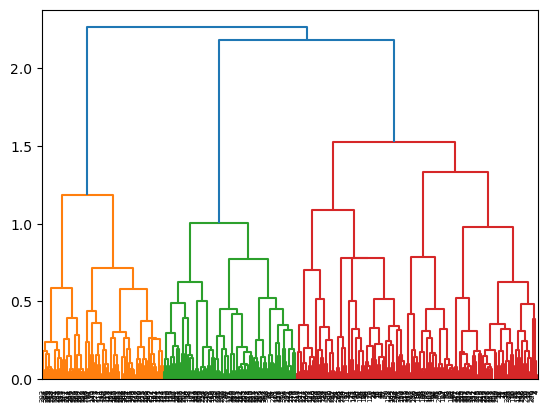

In [20]:
new_df = df.copy()
link = linkage(new_df, 'average', 'euclidean')
dn = dendrogram(link)

Методом средней связи было выделено 5 кластеров:

In [21]:
result = pd.DataFrame(fcluster(link, 5, criterion='maxclust'), columns=['target'])

Text(0.5, 1.0, 'predicted cluster')

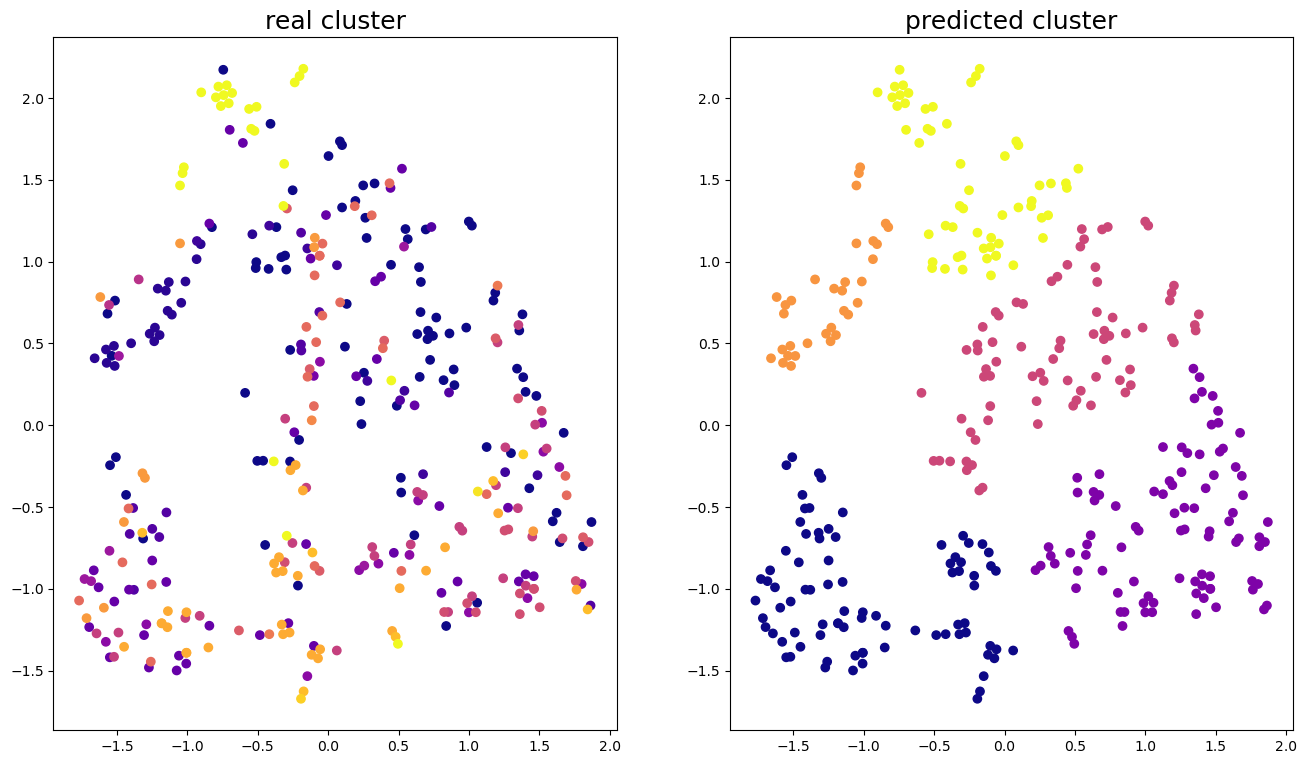

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16,9))
axes[0].scatter(new_df.iloc[:,0], new_df.iloc[:,1], c=target.values, cmap = plt.cm.plasma)
axes[0].set_title("real cluster", fontsize = 18)
axes[1].scatter(new_df.iloc[:,0], new_df.iloc[:,1], c=result.values, cmap = plt.cm.plasma)
axes[1].set_title("predicted cluster", fontsize = 18)

Оценим качество кластеризации:

In [23]:
print("Скорректированный индекс Рэнда: %0.3f" % adjusted_rand_score(target.values[:,0], result.values[:,0]))
print("Коэффициент изменения информации: %0.3f" % adjusted_mutual_info_score(target.values[:,0], result.values[:,0]))
print("Коэффициент качества кластеризации: %0.3f" % silhouette_score(new_df, result.values[:,0]))
print("Качество однородности: %0.3f" % homogeneity_score(target.values[:,0], result.values[:,0]))
print("Качество полноты: %0.3f" % completeness_score(target.values[:,0], result.values[:,0]))
print("Метрика V-Measure: %0.3f" % v_measure_score(target.values[:,0], result.values[:,0]))

Скорректированный индекс Рэнда: 0.106
Коэффициент изменения информации: 0.203
Коэффициент качества кластеризации: 0.436
Качество однородности: 0.203
Качество полноты: 0.330
Метрика V-Measure: 0.252


## Метод одиночной связи

Построим дендрограмму c использованием метода одиночной связи и Евклидового расстояния:

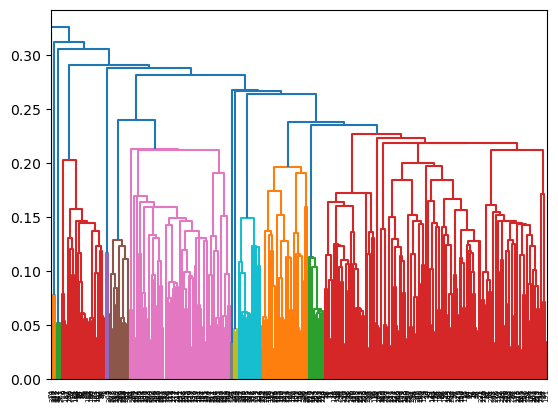

In [24]:
new_df = df.copy()
link = linkage(new_df, 'single', 'euclidean')
dn = dendrogram(link)

Методом одиночной связи было выделено 6 кластеров:

In [25]:
result = pd.DataFrame(fcluster(link, 6, criterion='maxclust'), columns=['target'])

Text(0.5, 1.0, 'predicted cluster')

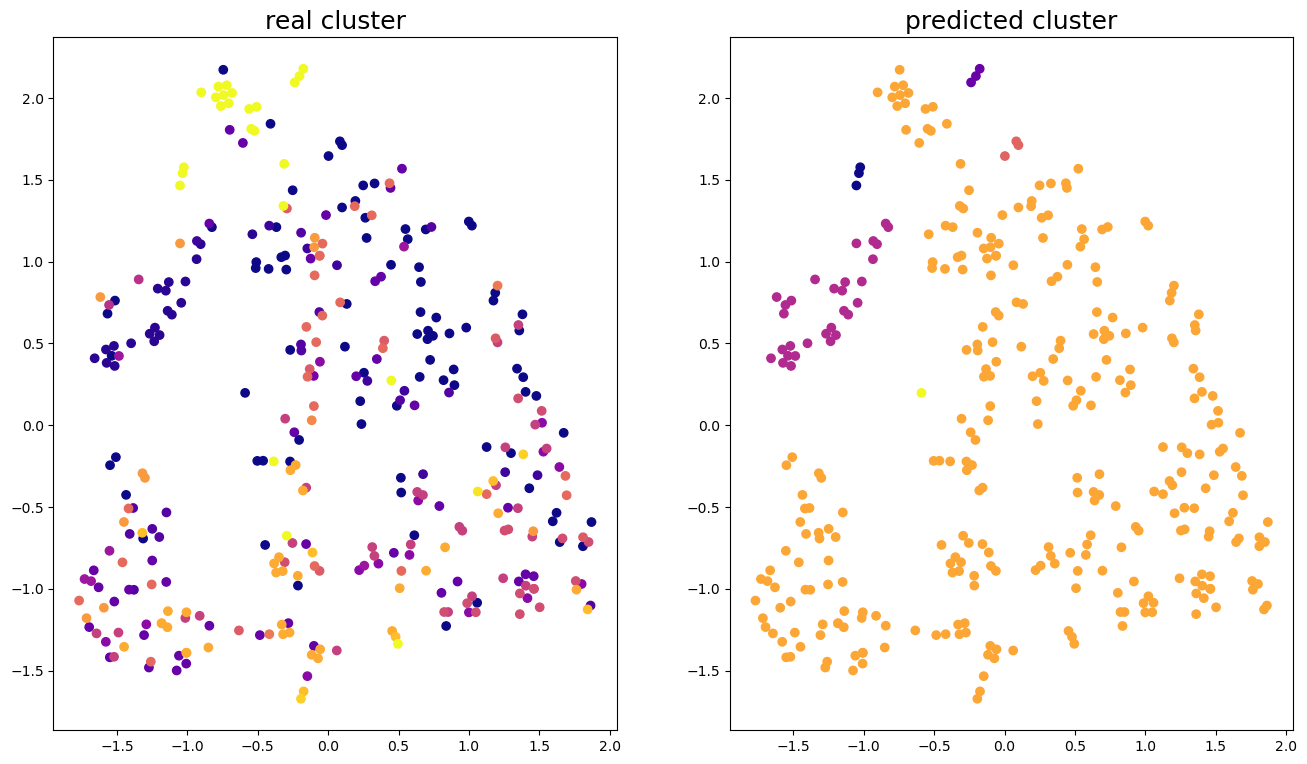

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(16,9))
axes[0].scatter(new_df.iloc[:,0], new_df.iloc[:,1], c=target.values, cmap = plt.cm.plasma)
axes[0].set_title("real cluster", fontsize = 18)
axes[1].scatter(new_df.iloc[:,0], new_df.iloc[:,1], c=result.values, cmap = plt.cm.plasma)
axes[1].set_title("predicted cluster", fontsize = 18)

Оценим качество кластеризации:

In [27]:
print("Скорректированный индекс Рэнда: %0.3f" % adjusted_rand_score(target.values[:,0], result.values[:,0]))
print("Коэффициент изменения информации: %0.3f" % adjusted_mutual_info_score(target.values[:,0], result.values[:,0]))
print("Коэффициент качества кластеризации: %0.3f" % silhouette_score(new_df, result.values[:,0]))
print("Качество однородности: %0.3f" % homogeneity_score(target.values[:,0], result.values[:,0]))
print("Качество полноты: %0.3f" % completeness_score(target.values[:,0], result.values[:,0]))
print("Метрика V-Measure: %0.3f" % v_measure_score(target.values[:,0], result.values[:,0]))

Скорректированный индекс Рэнда: 0.024
Коэффициент изменения информации: 0.126
Коэффициент качества кластеризации: -0.154
Качество однородности: 0.102
Качество полноты: 0.550
Метрика V-Measure: 0.172


# Итерационные алгоритмы кластерного анализа

## Метод k-средних

Посмотрим график для нахождения оптимального количества кластеров:

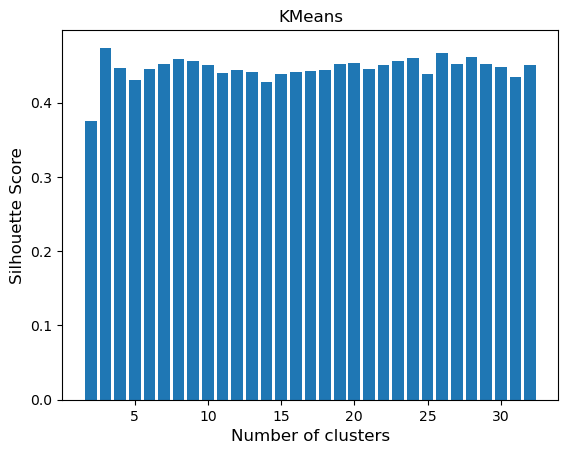

In [28]:
silhouette_scores = [] 
count = [x for x in range(2, 33)]

for n_cluster in count:
    silhouette_scores.append( 
        silhouette_score(new_df, KMeans(n_clusters = n_cluster, n_init = 10).fit_predict(new_df))) 
     
plt.bar(count, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 12) 
plt.ylabel('Silhouette Score', fontsize = 12)
plt.title('KMeans')
plt.show()

Оптимальное количество кластеров коэффициентом Силха считается 9.

### Анализ для неизвестного числа кластеров

In [29]:
new_df = df.copy()

Описываем модель для девяти кластеров, визуально оценненого оптимального количества кластеров по графику:

In [30]:
model = KMeans(n_clusters = 9, n_init = 10)
model.fit(new_df)

KMeans(n_clusters=9, n_init=10)

Прогнозируем:

In [31]:
prediction = model.predict(new_df)
result = pd.DataFrame(prediction, columns=['target'])
result.head()

,target
0,4
1,0
2,5
3,5
4,5


Подготавливаем данные для графика:

In [32]:
result = pd.DataFrame(prediction, columns=['target'])

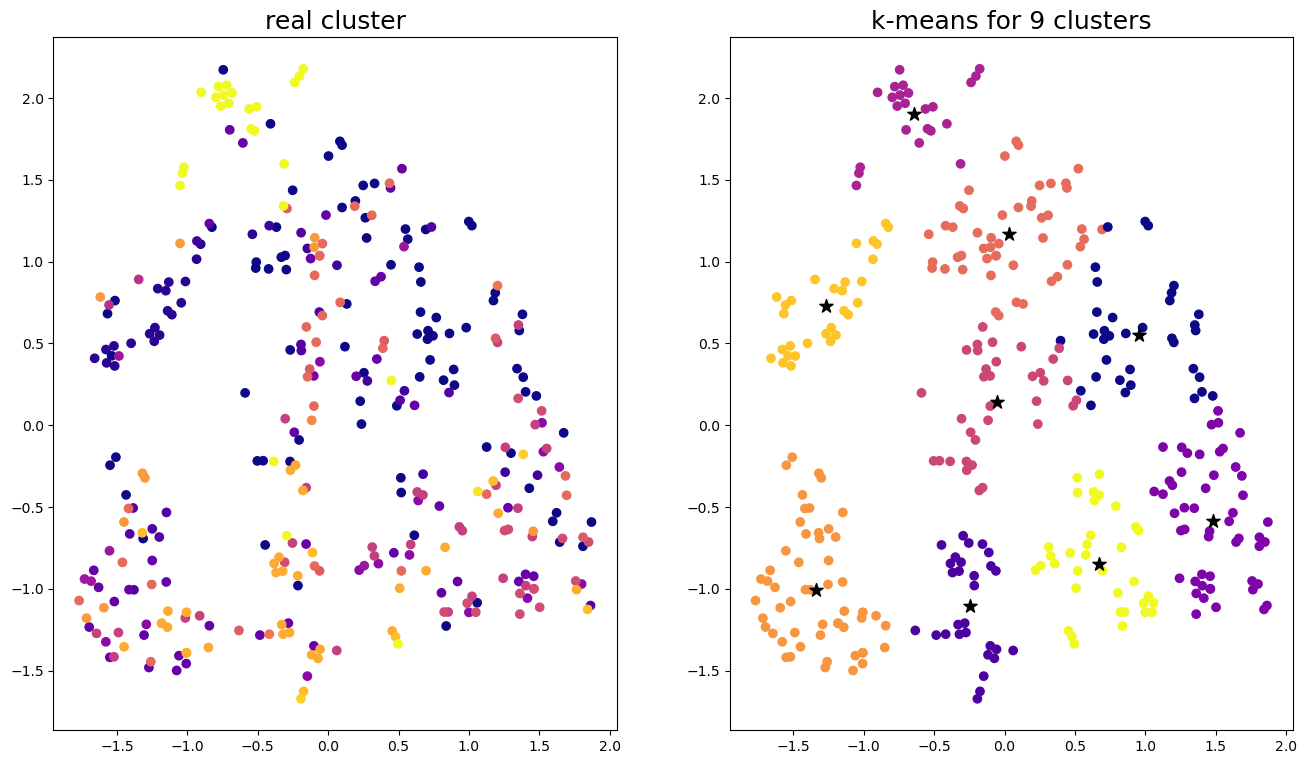

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(16,9))
axes[0].scatter(new_df.iloc[:,0], new_df.iloc[:,1], c=target.values, cmap = plt.cm.plasma)
axes[0].set_title("real cluster", fontsize = 18)
axes[1].scatter(new_df.iloc[:,0], new_df.iloc[:,1], c=result.values, cmap = plt.cm.plasma)
axes[1].set_title("k-means for 9 clusters", fontsize = 18)

plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s = 100, color='black', marker='*')

Оценим качество кластеризации:

In [34]:
print("Скорректированный индекс Рэнда: %0.3f" % adjusted_rand_score(target.values[:,0], result.values[:,0]))
print("Коэффициент изменения информации: %0.3f" % adjusted_mutual_info_score(target.values[:,0], result.values[:,0]))
print("Коэффициент качества кластеризации: %0.3f" % silhouette_score(new_df, result.values[:,0]))
print("Качество однородности: %0.3f" % homogeneity_score(target.values[:,0], result.values[:,0]))
print("Качество полноты: %0.3f" % completeness_score(target.values[:,0], result.values[:,0]))
print("Метрика V-Measure: %0.3f" % v_measure_score(target.values[:,0], result.values[:,0]))

Скорректированный индекс Рэнда: 0.132
Коэффициент изменения информации: 0.233
Коэффициент качества кластеризации: 0.456
Качество однородности: 0.288
Качество полноты: 0.337
Метрика V-Measure: 0.310


### Анализ для известного числа кластеров

Так как известно изначальное количество категорий, проведем анализ для 21 кластера:

In [35]:
new_df = df.copy()

In [36]:
model = KMeans(n_clusters=21, n_init = 10)
model.fit(new_df)

KMeans(n_clusters=21, n_init=10)

In [37]:
prediction = model.predict(new_df)
result = pd.DataFrame(prediction, columns=['target'])
result.head()

,target
0,17
1,5
2,20
3,20
4,20


Подготавливаем данные для графика:

In [38]:
result = pd.DataFrame(prediction, columns=['target'])

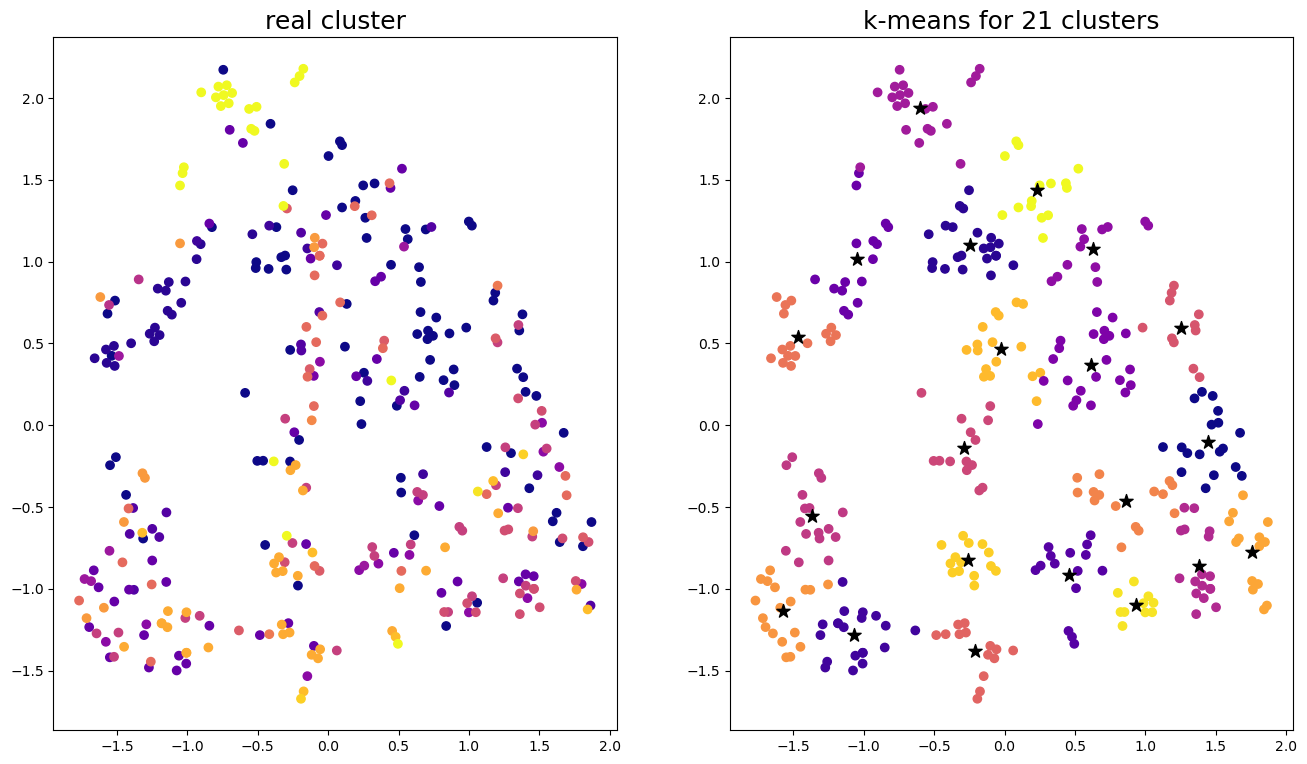

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(16,9))
axes[0].scatter(new_df.iloc[:,0], new_df.iloc[:,1], c=target.values, cmap = plt.cm.plasma)
axes[0].set_title("real cluster", fontsize = 18)
axes[1].scatter(new_df.iloc[:,0], new_df.iloc[:,1], c=result.values, cmap = plt.cm.plasma)
axes[1].set_title("k-means for 21 clusters", fontsize = 18)

plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s = 100, color='black', marker='*')

Оценим качество кластеризации:

In [40]:
print("Скорректированный индекс Рэнда: %0.3f" % adjusted_rand_score(target.values[:,0], result.values[:,0]))
print("Коэффициент изменения информации: %0.3f" % adjusted_mutual_info_score(target.values[:,0], result.values[:,0]))
print("Коэффициент качества кластеризации: %0.3f" % silhouette_score(new_df, result.values[:,0]))
print("Качество однородности: %0.3f" % homogeneity_score(target.values[:,0], result.values[:,0]))
print("Качество полноты: %0.3f" % completeness_score(target.values[:,0], result.values[:,0]))
print("Метрика V-Measure: %0.3f" % v_measure_score(target.values[:,0], result.values[:,0]))

Скорректированный индекс Рэнда: 0.099
Коэффициент изменения информации: 0.216
Коэффициент качества кластеризации: 0.449
Качество однородности: 0.397
Качество полноты: 0.332
Метрика V-Measure: 0.361


## Fuzzy C-Means алгоритм кластеризации

### Анализ для неизвестного числа кластеров

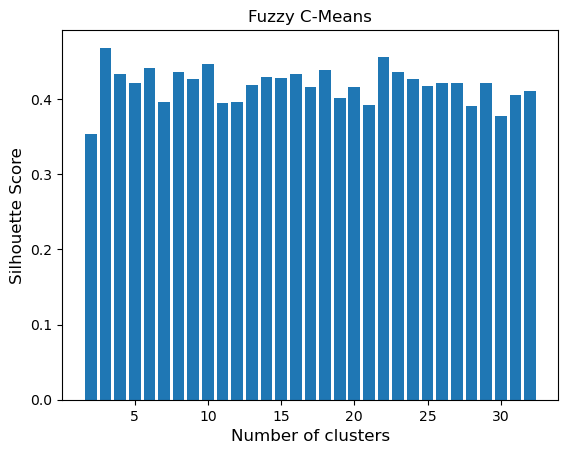

In [41]:
silhouette_scores = [] 
count = [x for x in range(2, 33)]

for n_cluster in count:
    model = FCM(n_clusters = n_cluster)
    model.fit(new_df.values)
    silhouette_scores.append(silhouette_score(new_df, model.predict(new_df.values))) 
     
plt.bar(count, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 12) 
plt.ylabel('Silhouette Score', fontsize = 12)
plt.title('Fuzzy C-Means')
plt.show()

In [42]:
new_df = df.copy()

Обучим модель нечеткой кластеризации с количеством кластеров равным 10:

In [43]:
model = FCM(n_clusters = 10)
model.fit(new_df.values)
center = model.centers

Спрогнозируем значения:

In [44]:
result = pd.DataFrame(model.predict(new_df.values), columns=['target'])
result.head()

,target
0,9
1,9
2,2
3,2
4,2


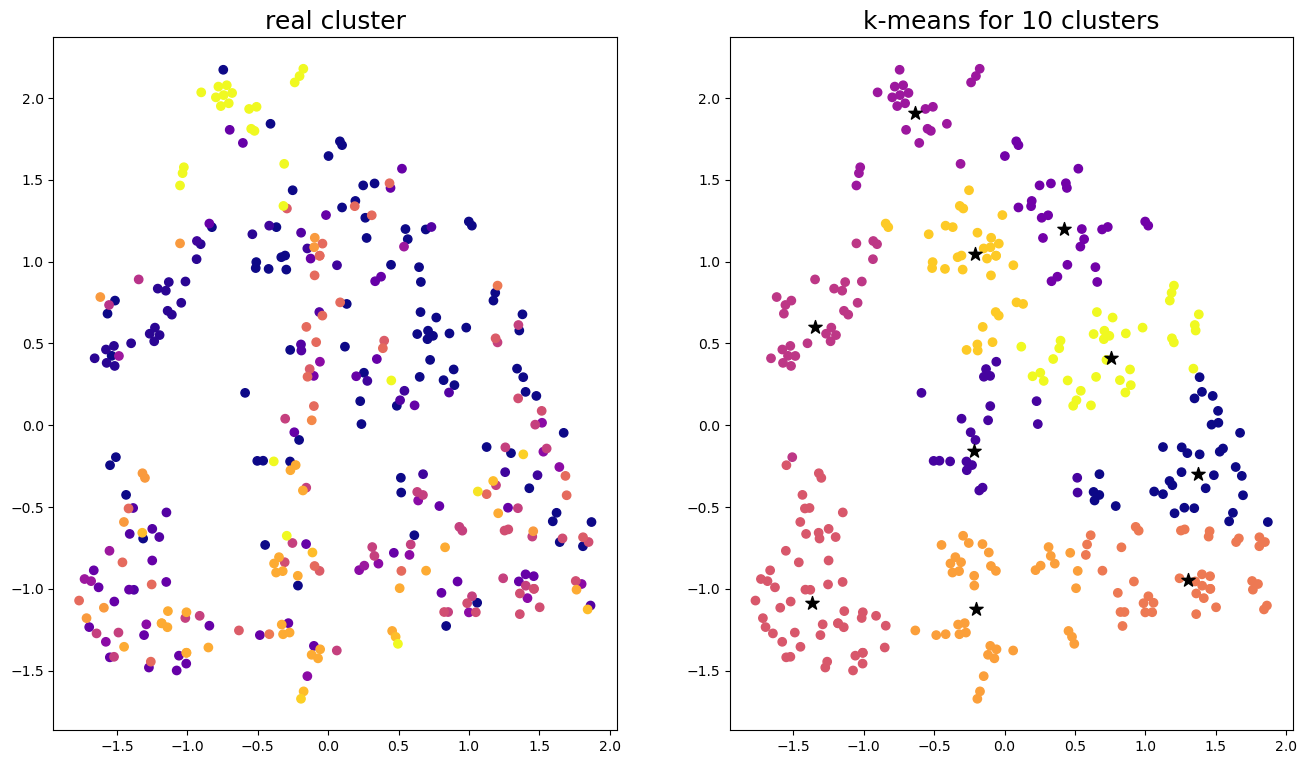

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(16,9))
axes[0].scatter(new_df.iloc[:,0], new_df.iloc[:,1], c=target.values, cmap = plt.cm.plasma)
axes[0].set_title("real cluster", fontsize = 18)
axes[1].scatter(new_df.iloc[:,0], new_df.iloc[:,1], c=result.values, cmap = plt.cm.plasma)
axes[1].set_title("k-means for 10 clusters", fontsize = 18)

plt.scatter(center[:,0], center[:,1], s = 100, color='black', marker='*')

Оценим качество кластеризации:

In [46]:
print("Скорректированный индекс Рэнда: %0.3f" % adjusted_rand_score(target.values[:,0], result.values[:,0]))
print("Коэффициент изменения информации: %0.3f" % adjusted_mutual_info_score(target.values[:,0], result.values[:,0]))
print("Коэффициент качества кластеризации: %0.3f" % silhouette_score(new_df, result.values[:,0]))
print("Качество однородности: %0.3f" % homogeneity_score(target.values[:,0], result.values[:,0]))
print("Качество полноты: %0.3f" % completeness_score(target.values[:,0], result.values[:,0]))
print("Метрика V-Measure: %0.3f" % v_measure_score(target.values[:,0], result.values[:,0]))

Скорректированный индекс Рэнда: 0.129
Коэффициент изменения информации: 0.251
Коэффициент качества кластеризации: 0.429
Качество однородности: 0.316
Качество полноты: 0.352
Метрика V-Measure: 0.333


### Анализ для известного числа кластеров

In [47]:
new_df = df.copy()

Модель для известной 21 категории признаков:

In [48]:
model = FCM(n_clusters = 21)
model.fit(new_df.values)
center = model.centers

In [49]:
result = pd.DataFrame(model.predict(new_df.values), columns=['target'])
result.head()

,target
0,1
1,14
2,15
3,15
4,15


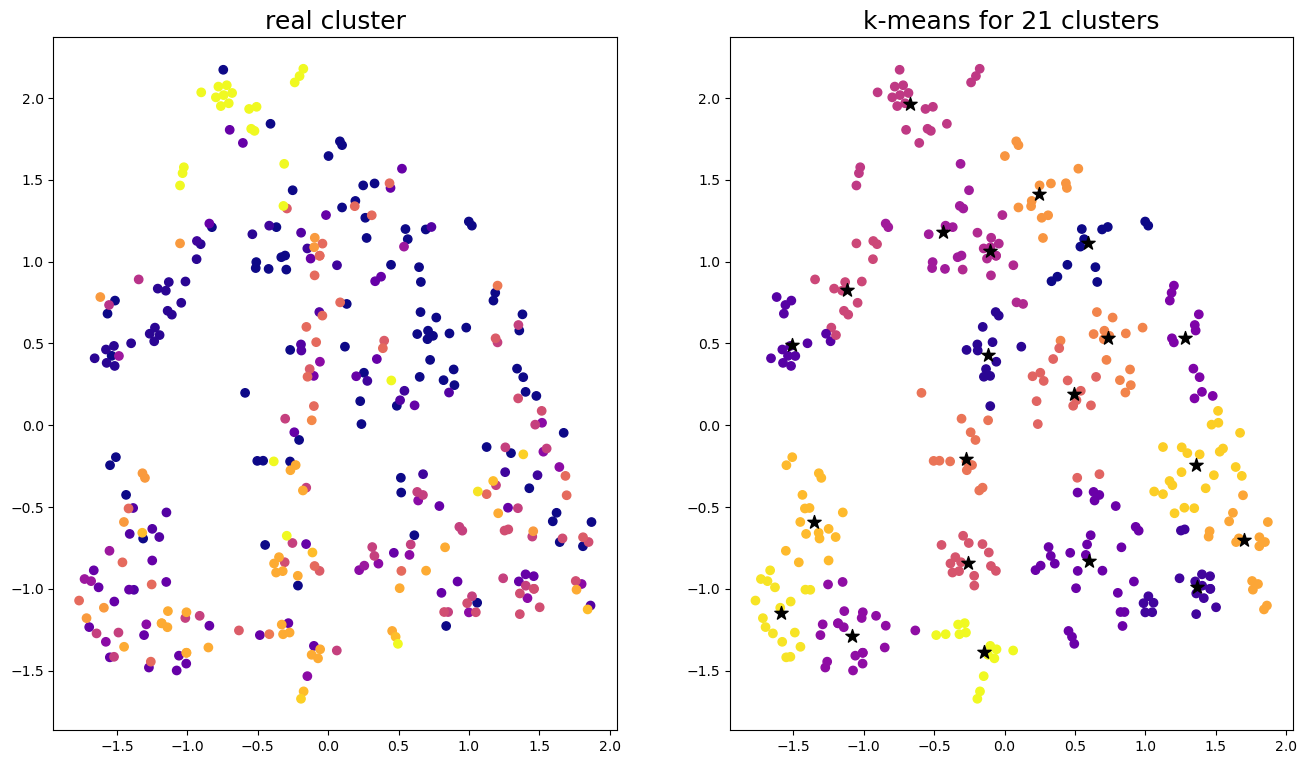

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(16,9))
axes[0].scatter(new_df.iloc[:,0], new_df.iloc[:,1], c=target.values, cmap = plt.cm.plasma)
axes[0].set_title("real cluster", fontsize = 18)
axes[1].scatter(new_df.iloc[:,0], new_df.iloc[:,1], c=result.values, cmap = plt.cm.plasma)
axes[1].set_title("k-means for 21 clusters", fontsize = 18)

plt.scatter(center[:,0], center[:,1], s = 100, color='black', marker='*')

Оценим качество кластеризации:

In [51]:
print("Скорректированный индекс Рэнда: %0.3f" % adjusted_rand_score(target.values[:,0], result.values[:,0]))
print("Коэффициент изменения информации: %0.3f" % adjusted_mutual_info_score(target.values[:,0], result.values[:,0]))
print("Коэффициент качества кластеризации: %0.3f" % silhouette_score(new_df, result.values[:,0]))
print("Качество однородности: %0.3f" % homogeneity_score(target.values[:,0], result.values[:,0]))
print("Качество полноты: %0.3f" % completeness_score(target.values[:,0], result.values[:,0]))
print("Метрика V-Measure: %0.3f" % v_measure_score(target.values[:,0], result.values[:,0]))

Скорректированный индекс Рэнда: 0.108
Коэффициент изменения информации: 0.239
Коэффициент качества кластеризации: 0.420
Качество однородности: 0.417
Качество полноты: 0.349
Метрика V-Measure: 0.380


## Метод кластеризации на основе плотности DBSCAN

In [52]:
new_df = df.copy()

Исследуем данные для оптимального определения значения эпсилон для дальнейшей кластеризации:

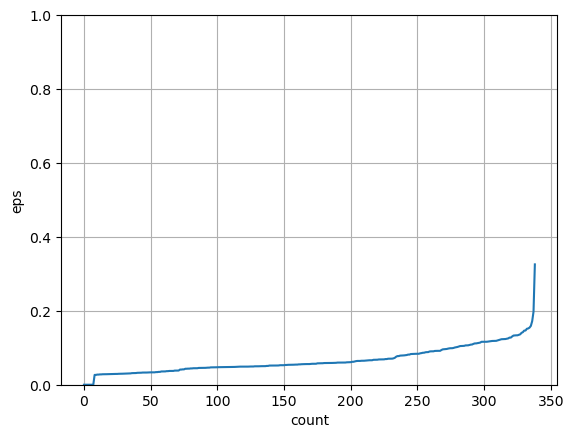

In [53]:
neighbors = NearestNeighbors(n_neighbors = 5)
neighbors_fit = neighbors.fit(df)
distances, indices = neighbors_fit.kneighbors(df)

distances = np.sort(distances, axis = 0)
distances = distances[:,1]
plt.ylim(0, 1)
plt.plot(distances)
plt.ylabel('eps')
plt.xlabel('count')
plt.grid()

Обучим модель:

In [54]:
model = DBSCAN(eps = 0.25, min_samples = 5)
model.fit(new_df)
result = pd.DataFrame(model.fit_predict(new_df), columns = ['target'])

Визуальный анализ и сравнение результатов кластеризации:

In [55]:
comp = PCA(n_components = 2).fit_transform(new_df)

Text(0.5, 1.0, 'dbscan')

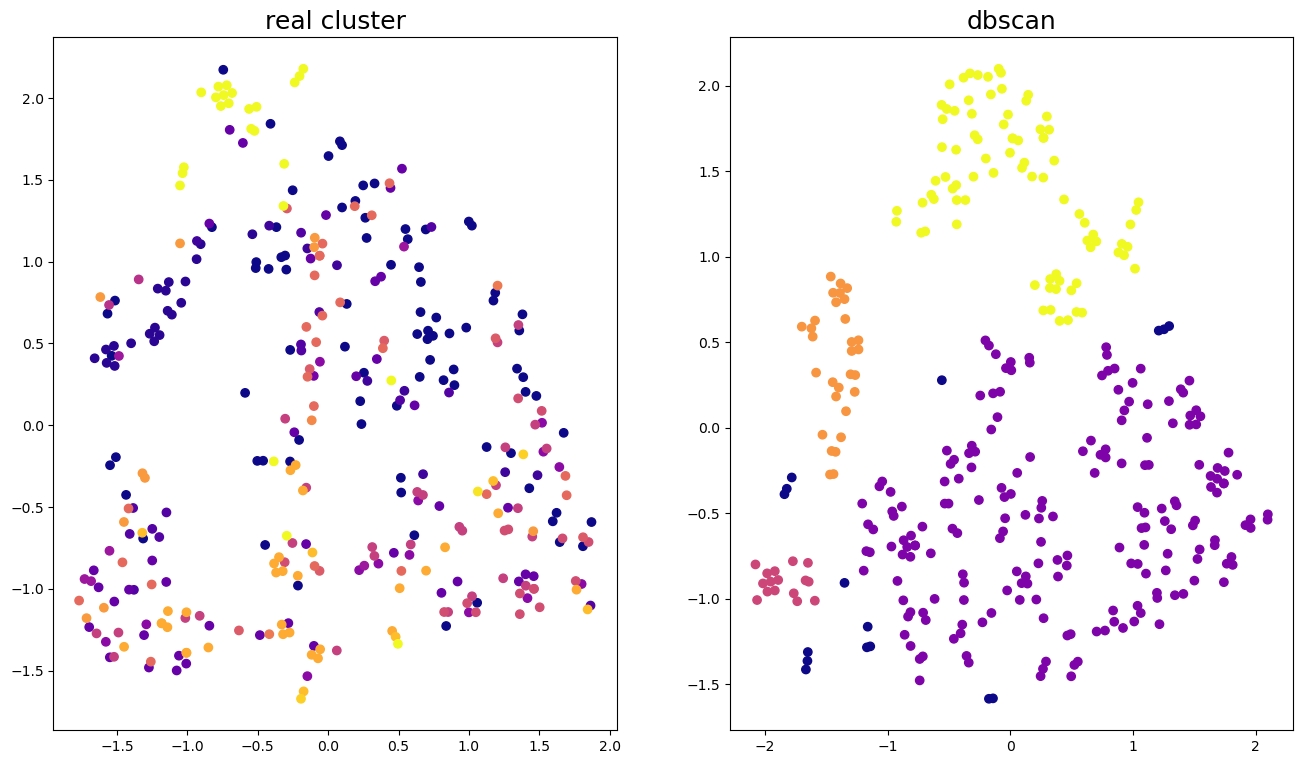

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(16,9))
axes[0].scatter(new_df.iloc[:,0], new_df.iloc[:,1], c = target.values, cmap = plt.cm.plasma)
axes[0].set_title("real cluster", fontsize = 18)
axes[1].scatter(comp[:,0], comp[:,1], c = result.values, cmap = plt.cm.plasma)
axes[1].set_title("dbscan", fontsize = 18)

Оценим кластеризацию:

In [57]:
print("Число кластеров: " + str(len(set(model.labels_))-1))
print("Количество шума: " + str(list(model.labels_).count(-1)))
print("Скорректированный индекс Рэнда: %0.3f" % adjusted_rand_score(target.values[:,0], result.values[:,0]))
print("Коэффициент изменения информации: %0.3f" % adjusted_mutual_info_score(target.values[:,0], result.values[:,0]))
print("Коэффициент качества кластеризации: %0.3f" % silhouette_score(new_df, result.values[:,0]))
print("Качество однородности: %0.3f" % homogeneity_score(target.values[:,0], result.values[:,0]))
print("Качество полноты: %0.3f" % completeness_score(target.values[:,0], result.values[:,0]))
print("Метрика V-Measure: %0.3f" % v_measure_score(target.values[:,0], result.values[:,0]))

Число кластеров: 4
Количество шума: 16
Скорректированный индекс Рэнда: 0.098
Коэффициент изменения информации: 0.201
Коэффициент качества кластеризации: 0.301
Качество однородности: 0.183
Качество полноты: 0.397
Метрика V-Measure: 0.251


# Вывод

Этот набор данных содержит категориальные и бинарные аттрибуты для задачи классификации первичных опухолей пациентов медицинского центра онкологии Любляна. Для классификации были использованы различные алгоритмы кластерного анализа, однако после понижения размерности наиболее релевантными алгоритмами оказались kmeans, базирующийся на расстоянии между объектами и DBSCAN, основанный на плотности в пространстве, группируя близко расположенные точки.